In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Wczytanie danych
df = pd.read_csv('messy_data.csv')

# Poprawa nazw kolumn (usunięcie spacji przed nazwami kolumn)
df.columns = df.columns.str.strip()

# 1a. Usunięcie duplikatów
df.drop_duplicates(inplace=True)

# 1b. Identyfikacja i obsługa wartości odstających
numeric_columns = ['carat', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table', 'price']

# Konwersja kolumn numerycznych do float
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Usunięcie wierszy z brakującymi danymi w kolumnie 'price'
df_no_price = df.dropna(subset=['price'])

# Identyfikacja i obsługa wartości odstających
Q1 = df_no_price[numeric_columns].quantile(0.25)
Q3 = df_no_price[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
df_clean = df_no_price[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]


<ipython-input-19-c8cb6970ddf2>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_no_price[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [20]:
selected_columns = [col for col in df.columns if col != 'price']

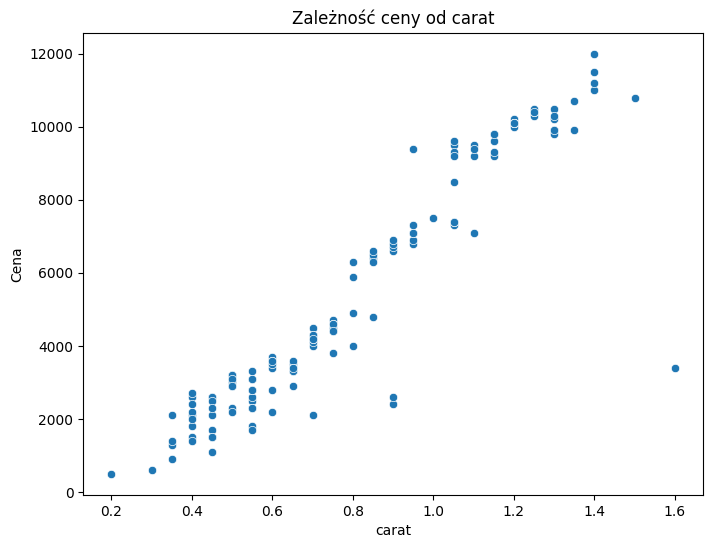

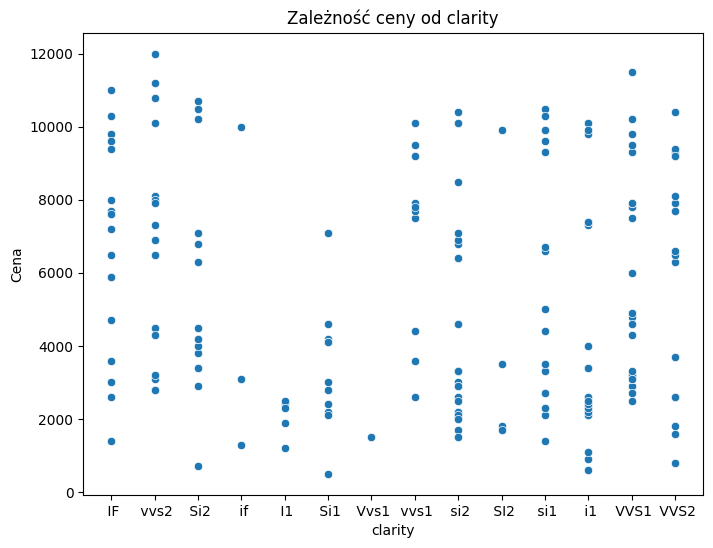

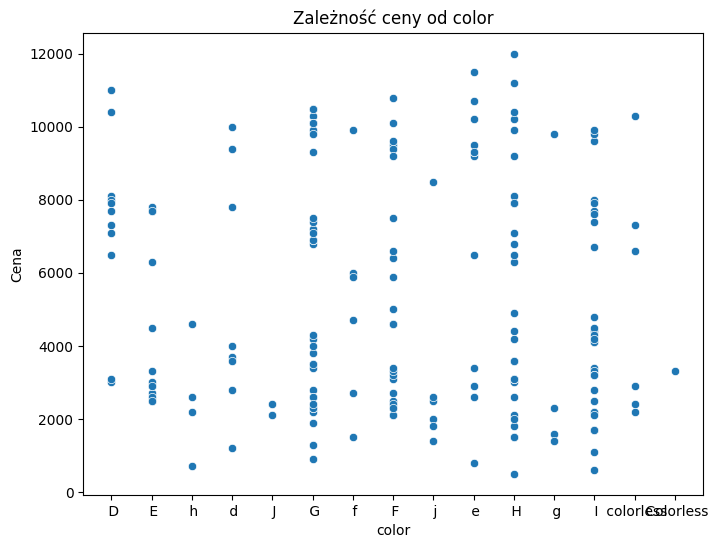

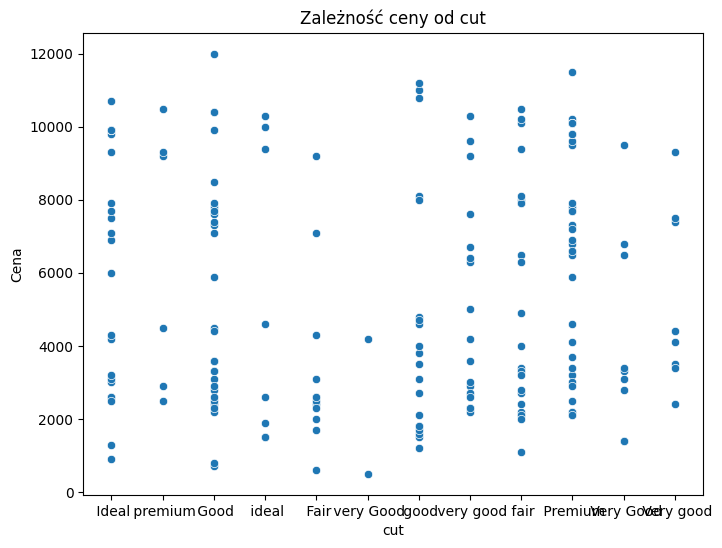

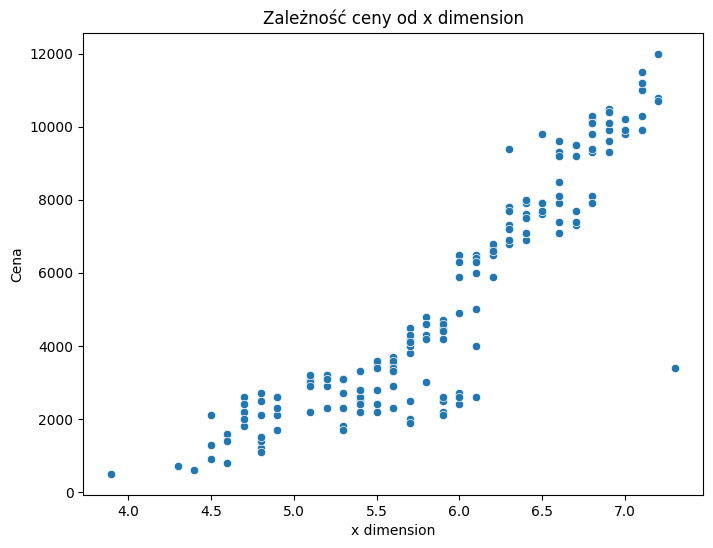

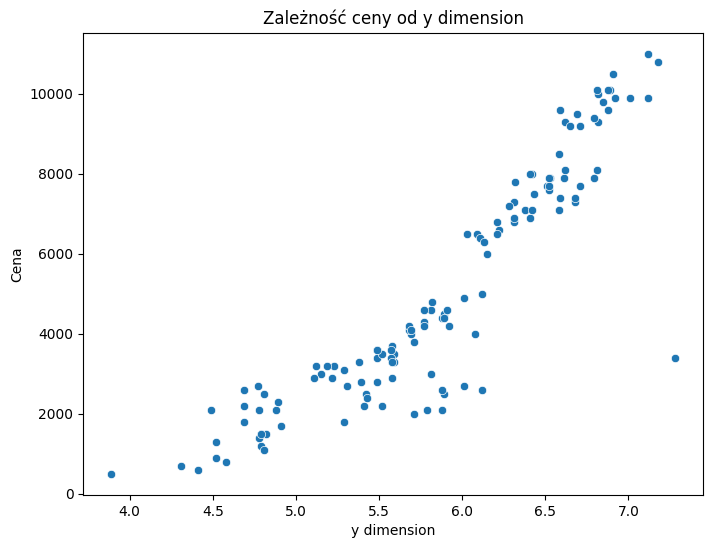

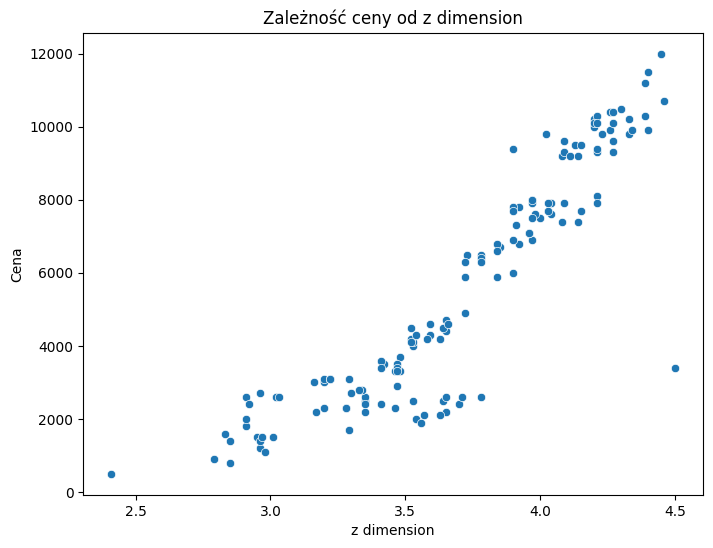

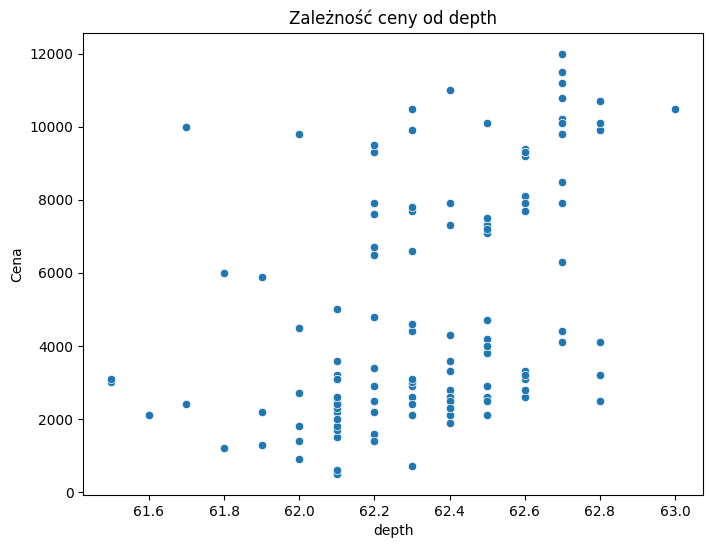

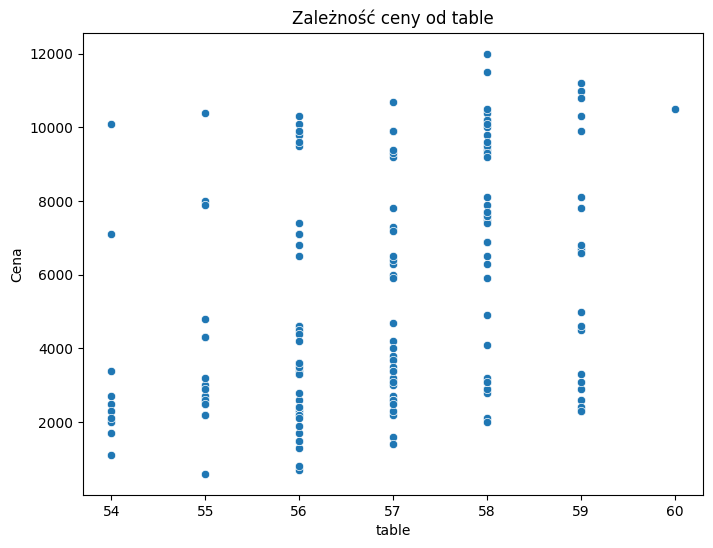

In [21]:
# 2. Analiza zależności ceny od pozostałych parametrów (wykresy punktowe)
for col in selected_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='price', data=df_clean)
    plt.title(f'Zależność ceny od {col}')
    plt.xlabel(col)
    plt.ylabel('Cena')
    plt.show()

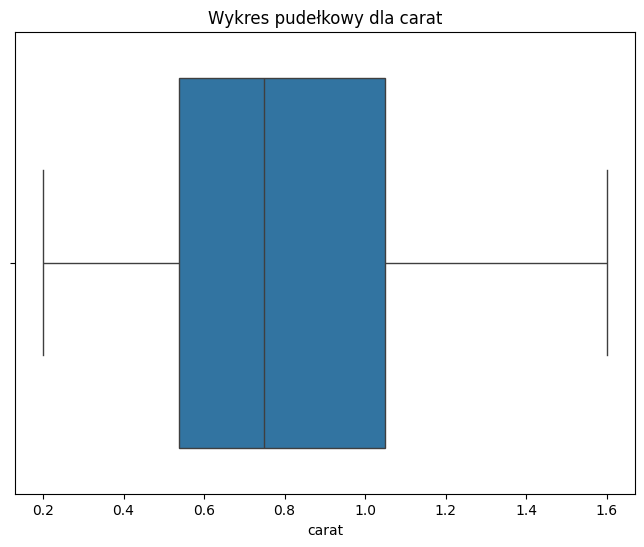

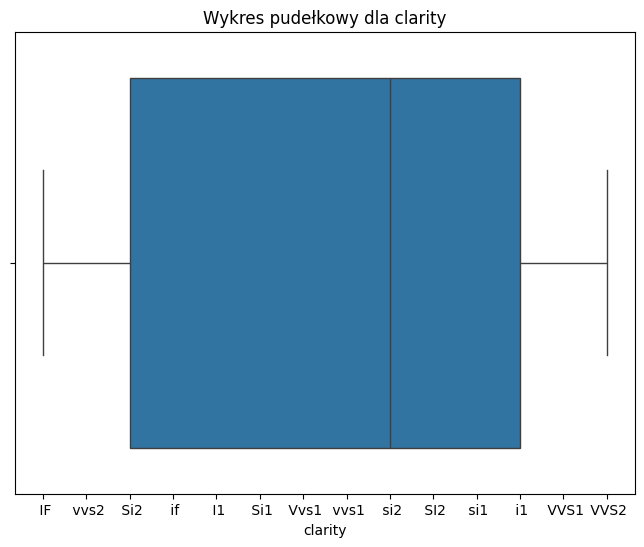

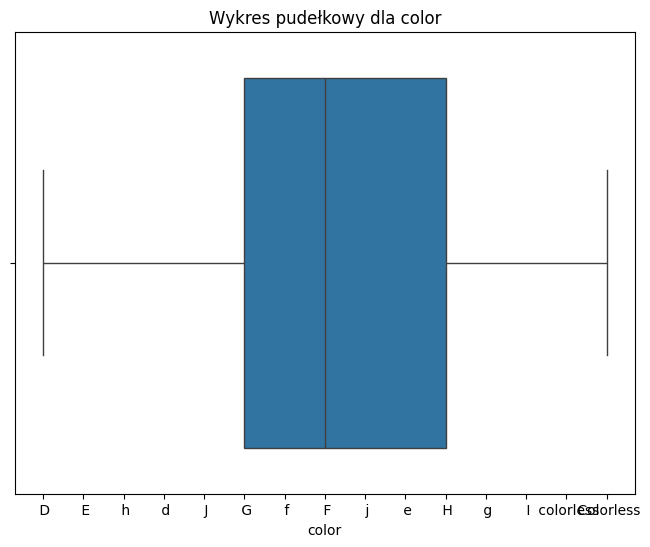

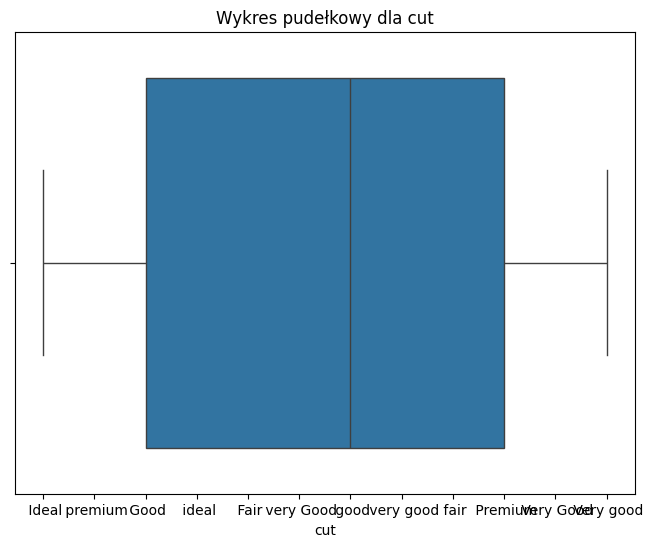

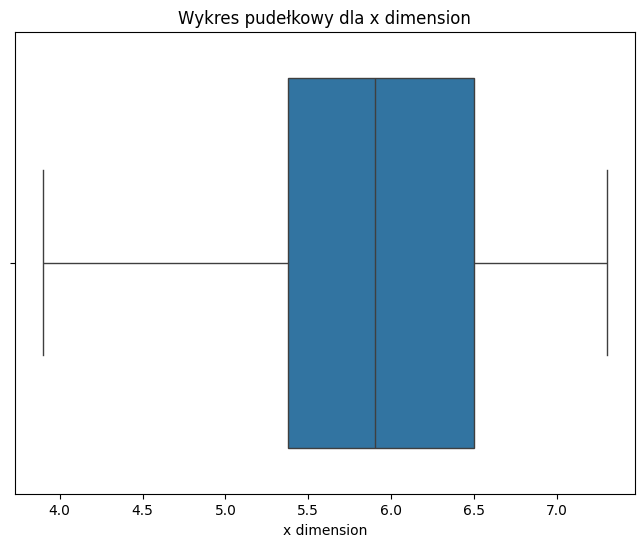

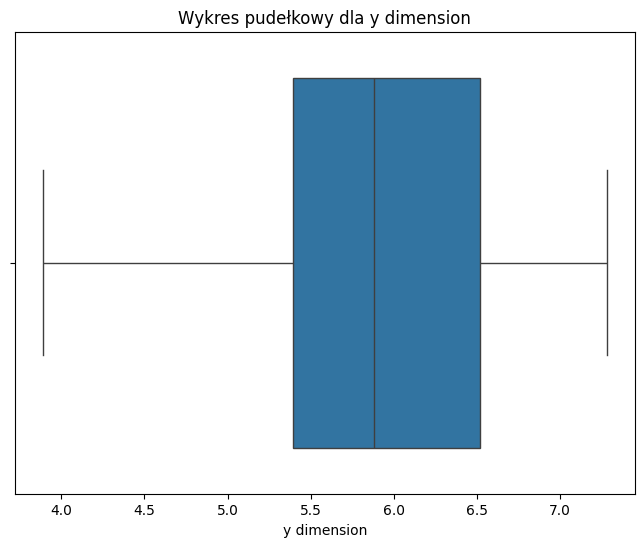

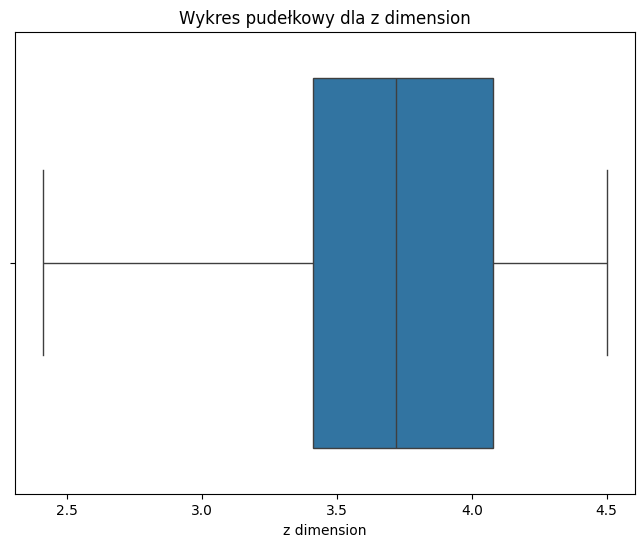

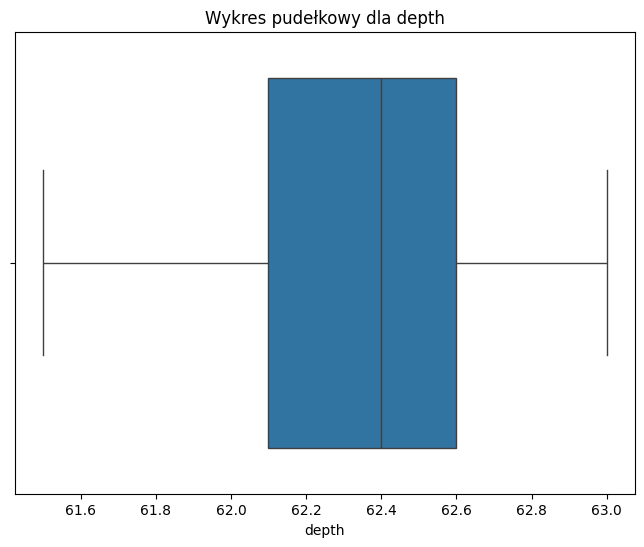

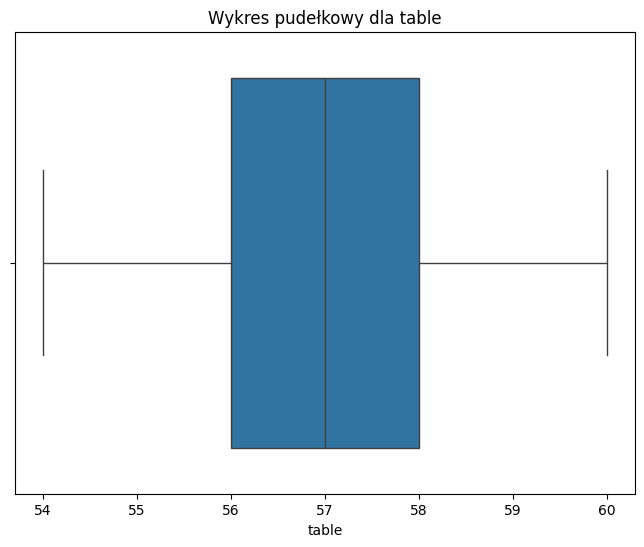

In [22]:
# 3. Wykresy pudełkowe dla istotnych danych
for col in selected_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, data=df_clean)
    plt.title(f'Wykres pudełkowy dla {col}')
    plt.xlabel(col)
    plt.show()

In [23]:
# Uzupełnienie brakujących danych w pozostałych kolumnach
df_clean.loc[:, numeric_columns] = df_clean[numeric_columns].fillna(df_clean[numeric_columns].mean(numeric_only=True))

# 1e. Normalizacja skali wartości
# Normalizacja kolumn numerycznych
df_clean.loc[:, numeric_columns] = (
    df_clean[numeric_columns] - df_clean[numeric_columns].min()) / (
    df_clean[numeric_columns].max() - df_clean[numeric_columns].min())

# 4. Budowa modelu regresji ceny od pozostałych zmiennych
X = df_clean[selected_columns]
y = df_clean['price']

# Kodowanie kategorycznych danych jakościowych
X_encoded = pd.get_dummies(X, columns=['clarity', 'color', 'cut'], drop_first=True)

# Podział danych na zbiór treningowy, walidacyjny i testowy
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Budowa modelu regresji
model = LinearRegression()

<ipython-input-23-b2d887831144>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, numeric_columns] = df_clean[numeric_columns].fillna(df_clean[numeric_columns].mean(numeric_only=True))
<ipython-input-23-b2d887831144>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, numeric_columns] = (


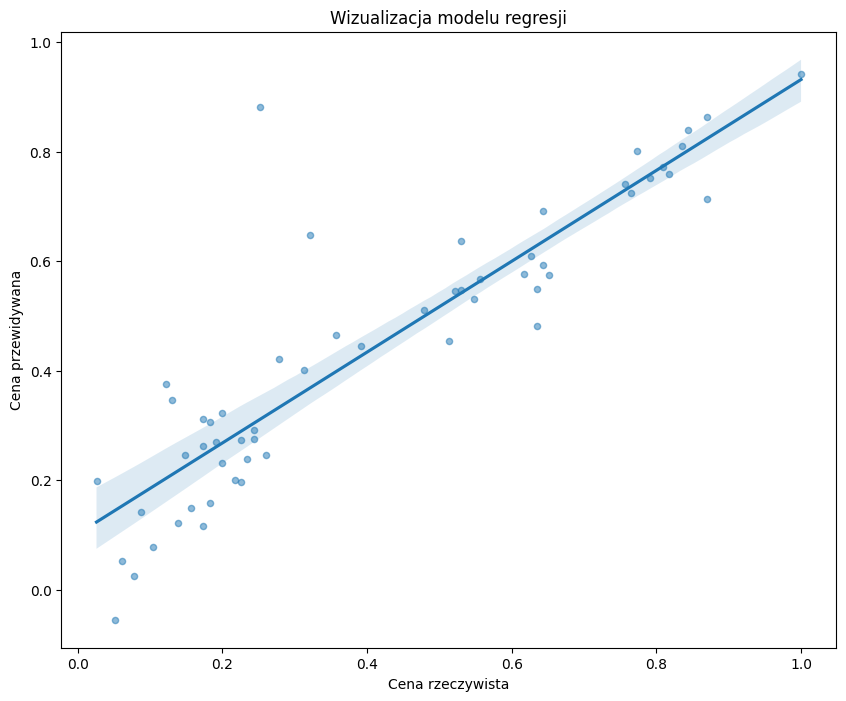

Mean Squared Error (MSE): 0.01557133206690255
R-squared (R^2): 0.7886102150600169


In [24]:
# Eliminacja wsteczna (backward elimination)
selector = RFE(model, step=1)
selector = selector.fit(X_train, y_train)

# Wybór istotnych zmiennych
selected_columns = X_encoded.columns[selector.support_]

# Budowa modelu z istotnymi zmiennymi
model.fit(X_train[selected_columns], y_train)

# Ocena modelu na zbiorze testowym
y_pred = model.predict(X_test[selected_columns])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 5. Wizualizacja modelu regresji
plt.figure(figsize=(10, 8))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.5})
plt.title('Wizualizacja modelu regresji')
plt.xlabel('Cena rzeczywista')
plt.ylabel('Cena przewidywana')
plt.show()

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R^2): {r2}")